<a href="https://colab.research.google.com/github/yangyang1598/Deeplearning/blob/main/segmentation_advence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation with advence

## 데이터셋: Oxford-IIIT Pets 데이터셋
---
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/oxford-pet.jpeg?raw=true)

### 1. 데이터셋 다운로드

In [ ]:
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  19.0M      0  0:00:39  0:00:39 --:--:-- 20.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  7176k      0  0:00:02  0:00:02 --:--:-- 7173k


### 2. 이미지 경로 설정

In [ ]:
import os
from glob import glob

data_dir= '/content/'
#Train
train_img_paths=glob(os.path.join(data_dir,'images/*.jpg'))
train_mask_paths=glob(os.path.join(data_dir,'annotations/trimaps/*.png'))

print(len(train_img_paths),len(train_mask_paths))
print(train_img_paths[:10])
print(train_mask_paths[:10])

train_img_paths=sorted(train_img_paths)
train_mask_paths=sorted(train_mask_paths)



7390 7390
['/content/images/wheaten_terrier_192.jpg', '/content/images/British_Shorthair_268.jpg', '/content/images/Persian_262.jpg', '/content/images/basset_hound_33.jpg', '/content/images/miniature_pinscher_154.jpg', '/content/images/basset_hound_153.jpg', '/content/images/leonberger_190.jpg', '/content/images/japanese_chin_77.jpg', '/content/images/wheaten_terrier_168.jpg', '/content/images/boxer_40.jpg']
['/content/annotations/trimaps/american_pit_bull_terrier_136.png', '/content/annotations/trimaps/staffordshire_bull_terrier_93.png', '/content/annotations/trimaps/Siamese_81.png', '/content/annotations/trimaps/Bombay_100.png', '/content/annotations/trimaps/staffordshire_bull_terrier_94.png', '/content/annotations/trimaps/pug_146.png', '/content/annotations/trimaps/pomeranian_139.png', '/content/annotations/trimaps/Birman_157.png', '/content/annotations/trimaps/Russian_Blue_130.png', '/content/annotations/trimaps/samoyed_111.png']


## 데이터셋 제너레이터
---

In [ ]:
#img_size=128
#img=img/255 ->0~1 사이 값이 나옴
#img=(img/127.5)-1 ->-1~1 사이 값 나옴
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') #plot 스타일 조절

class DataGenerator():
  def __init__(self,img_size,batch_size):
    self.img_size= img_size
    self.batch_size=batch_size
  def path2arr(self,path,mask=False):
    #mask의 경우에는 컬러모드가 rgb가 아님.so, mask-False

    #img 일때
    if not mask:
      #path->img
      img=load_img(path,color_mode='rgb',target_size=(self.img_size,self.img_size))
      #img->arr
      arr=img_to_array(img,dtype='uint8')
    else:
      #path->img
      img=load_img(path,color_mode='grayscale',target_size=(self.img_size,self.img_size))
      #img->arr
      arr=img_to_array(img,dtype='uint8')

    return arr
  def load_datasets(self,img_paths,mask_paths):
    img_arrs=[]
    mask_arrs=[]
    for img_path,mask_path in zip(img_paths,mask_paths):
      img_arr=self.path2arr(img_path)
      mask_arr=self.path2arr(mask_path,mask=True)
      img_arrs.append(img_arr)
      mask_arrs.append(mask_arr)
    return np.array(img_arrs),np.array(mask_arrs)

  def preprocess(self,img_arr,mask_arr):
    img_arr=(tf.cast(img_arr,tf.float32)/127.5)-1
    mask_arr=tf.cast(mask_arr,tf.float32)-1
    return img_arr,mask_arr


  def generate(self,img_paths,mask_paths):
    img_arrs,mask_arrs=self.load_datasets(img_paths,mask_paths)
    dataset=tf.data.Dataset.from_tensor_slices((img_arrs,mask_arrs))
    dataset=dataset.map(self.preprocess,num_parallel_calls=tf.data.AUTOTUNE)
    dataset=dataset.batch(self.batch_size,drop_remainder=True)

    return dataset
    

def hist_val(img_arr,mask_arr):
  plt.figure(figsize=(20,10)) #plt 사이즈 조정
  plt.subplot(1,2,1)
  img_shape=img_arr.shape[0]*img_arr.shape[1]*img_arr.shape[2]
  plt.hist(np.reshape(img_arr,img_shape))#hist는 무조건 1차원 값이 들어가야함

  plt.subplot(1,2,2)
  mask_shape=mask_arr.shape[0]*mask_arr.shape[1]*mask_arr.shape[2]
  plt.hist(np.reshape(mask_arr,mask_shape))
  print(set(np.reshape(mask_arr,mask_shape))) #set은 값들의 중복값은 제거 (112321 -> 123)
  plt.show()



def display_img(img_arr,mask_arr,mask_cmap=None):
  plt.figure(figsize=(12,4))
  
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img_arr)

  plt.subplot(1,3,2) #중첩되도록 그림
  plt.axis('off')
  plt.imshow(img_arr)
  plt.imshow(mask_arr[:,:,0],alpha=0.6,cmap=mask_cmap) #alpha 투명도 cmap 컬러맵(기본 값 None)

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask_arr[:,:,0],cmap=mask_cmap)#mask_arr (가로,세로,1)->(가로,세로)

  plt.show()

In [ ]:
IMG_SIZE = 256
BATCH_SIZE=16
dg=DataGenerator(IMG_SIZE,BATCH_SIZE)


### 1. array 변환

In [ ]:
idx=12
img_arr=dg.path2arr(train_img_paths[idx])
mask_arr=dg.path2arr(train_mask_paths[idx],mask=True)
print(img_arr.shape,mask_arr.shape)

(256, 256, 3) (256, 256, 1)


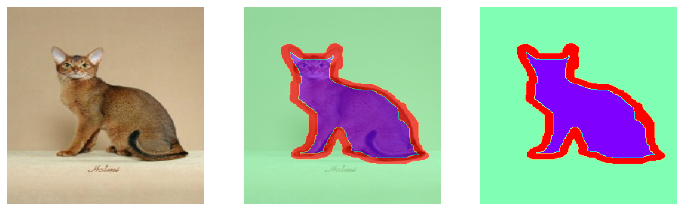

{1, 2, 3}


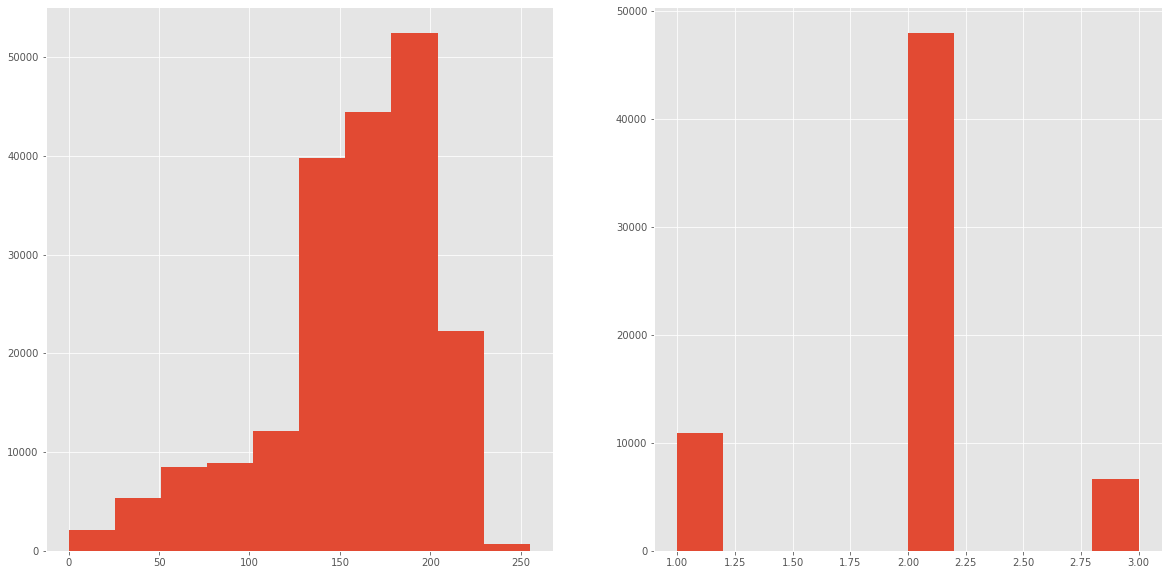

In [ ]:
display_img(img_arr,mask_arr,mask_cmap='rainbow')
hist_val(img_arr,mask_arr)
#img = 0~255 ,imput
#mask = 0~19 ,output(이미지에 마스크가 씌워져서 나옴)

### 2. 전처리

In [ ]:
img_pre,mask_pre=dg.preprocess(img_arr,mask_arr)
print(img_pre.shape,mask_pre.shape)

(256, 256, 3) (256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


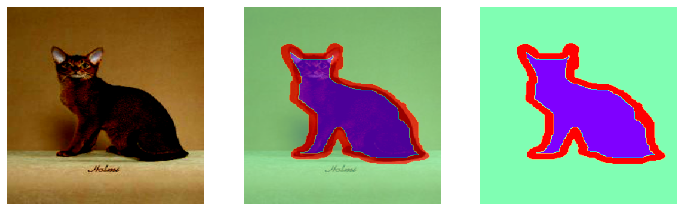

{0.0, 1.0, 2.0}


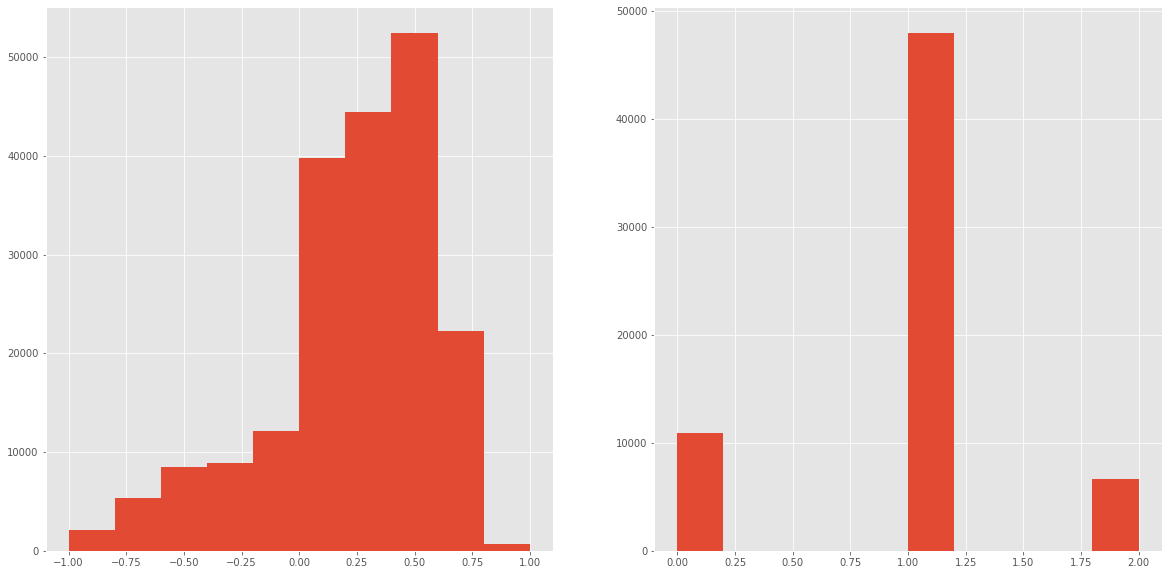

In [ ]:
display_img(img_pre,mask_pre,mask_cmap='rainbow')
hist_val(img_pre,mask_pre)
#img = 0~255 ,imput
#mask = 0~19 ,output(이미지에 마스크가 씌워져서 나옴)

### 3. 데이터셋 정의


In [ ]:
train_ds=dg.generate(train_img_paths[:5000],train_mask_paths[:5000])
valid_ds=dg.generate(train_img_paths[5000:],train_mask_paths[5000:])
print(train_ds)

<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>


## 모델: UNet
---

### 1. 모델 생성

In [ ]:
from tensorflow.keras import layers, models, Input, utils

def get_unet(img_size, num_classes):
  inputs = Input(shape=( img_size, img_size, 3) )

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x

  for filters in [64, 128, 256]:
    #filter :채널
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

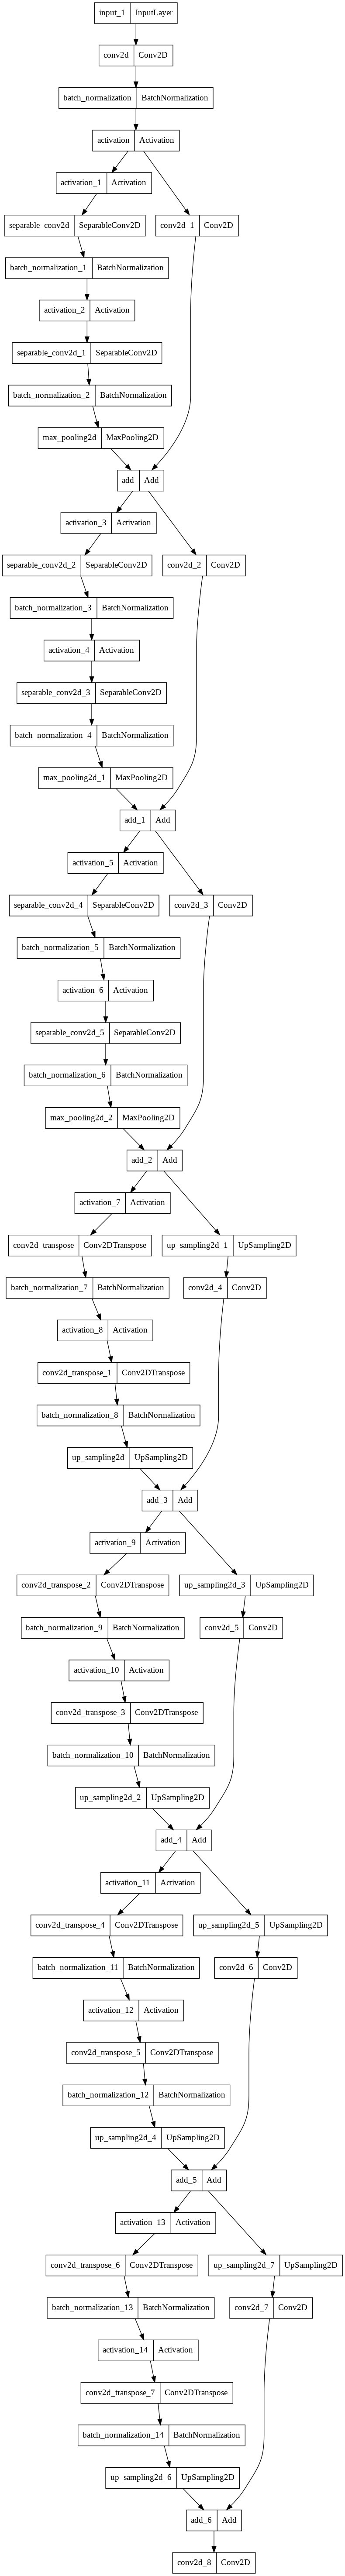

In [ ]:
NUM_CLASSES =20 #mask의 갯수에 맞게 설정, 해당 경우에는 20개이므로 20개
model=get_unet(IMG_SIZE,NUM_CLASSES)
tf.keras.utils.plot_model(model)

### 2. 모델 컴파일

In [ ]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

### 3. 모델 학습

In [ ]:
ckp= tf.keras.callbacks.ModelCheckpoint("unet_chip.h5",save_best_only=True)#save_best_only:가장 좋은 모델만 저장하겠다
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.2,
                                               patience=5)
history= model.fit(train_ds
                   ,validation_data=valid_ds
                   ,epochs=10
                   ,callbacks=[ckp,reduce_lr]) #callback:학습성능향상 모듈


Epoch 1/10
158/312 [==============>...............] - ETA: 23:44 - loss: 0.9162 - accuracy: 0.6739

### 4. 모델 평가

### 5. 추론

## Generator with augmentation
---


### augmentation

### 데이터셋 정의

## 모델: 전이학습

### 1. 모델 생성

### 2. 모델 컴파일

### 3. 모델 학습

### 4. 모델 평가

### 5. 추론

In [ ]:
3